In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import pandas as pd
from pytz import utc
import os
import mlflow
import numpy as np
import matplotlib.pyplot as plt

# mlflow imports
from mlflow.models.signature import infer_signature

# sklearn imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# oma_tracking imports
from oma_tracking.data.utils import read_simulations_csv_files
from oma_tracking.data import make_dataset
from oma_tracking.data.preprocessing import AngleTransformer, sin_cos_angle_inputs
import oma_tracking.models.mlflow_functions as mlflow_f
from oma_tracking.models.utils import convert_dict

from dotenv import load_dotenv
load_dotenv()

# data selection imports
from xgboost import XGBRegressor
from shaphypetune import BoostSearch, BoostRFE, BoostRFA, BoostBoruta
from hyperopt import Trials
from hyperopt import hp

import warnings
warnings.filterwarnings('ignore')

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_

In [3]:
start =  datetime.datetime(2022,10,1,tzinfo=utc)
stop  = datetime.datetime(2023,7,4,tzinfo=utc)
location = 'nw2c02'
name_location = 'NW2C02'

# Data Paths
data_root = "../../../"
data_path = data_root + "data/nw2/raw/" + location + "_" + start.strftime("%Y%m%d") + "_" + stop.strftime("%Y%m%d") + ".parquet"
mvbc_path = data_root + "data/nw2/mvbc_data.parquet"
SS1_path = data_root + "data/nw2/tracked_modes/SS1_" + name_location  + ".parquet"
SS2_path = data_root + "data/nw2/tracked_modes/SS2_" + name_location  + ".parquet"

# Get all the data
data = pd.read_parquet(data_path)
mvbc_data = pd.read_parquet(mvbc_path)
SS1_tracked = pd.read_parquet(SS1_path)
SS2_tracked = pd.read_parquet(SS2_path)

SS1_sorted = SS1_tracked.sort_values(['timestamp', 'size'])
SS1_sorted[SS1_sorted.index.duplicated(keep='last')]
SS1_drop_duplicates = SS1_sorted[~SS1_sorted.index.duplicated(keep='last')]

SS2_sorted = SS2_tracked.sort_values(['timestamp', 'size'])
SS2_sorted[SS2_sorted.index.duplicated(keep='last')]
SS2_drop_duplicates = SS2_sorted[~SS2_sorted.index.duplicated(keep='last')]

SS1_frequency = SS1_drop_duplicates.frequency
SS2_frequency = SS2_drop_duplicates.frequency

scada_inputs = make_dataset.get_scada_subset(data)
weather_data = mvbc_data[mvbc_data.columns[mvbc_data.isna().sum() < len(mvbc_data) * 0.1]]

inputs = \
    pd.concat(
        [
            weather_data,
            scada_inputs
        ],
        axis=1
    )

In [4]:
scada_inputs = make_dataset.get_scada_subset(data)
weather_data = mvbc_data[mvbc_data.columns[mvbc_data.isna().sum() < len(mvbc_data) * 0.1]]
inputs = \
    pd.concat(
        [
            weather_data,
            scada_inputs
        ],
        axis=1
    )
angle_transformed_inputs = sin_cos_angle_inputs(inputs, angle_type = 'degrees', angles = ['winddirection', 'yaw'])

In [5]:
mvbc_data.columns

Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Relative_humidity',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature'],
      dtype='object')

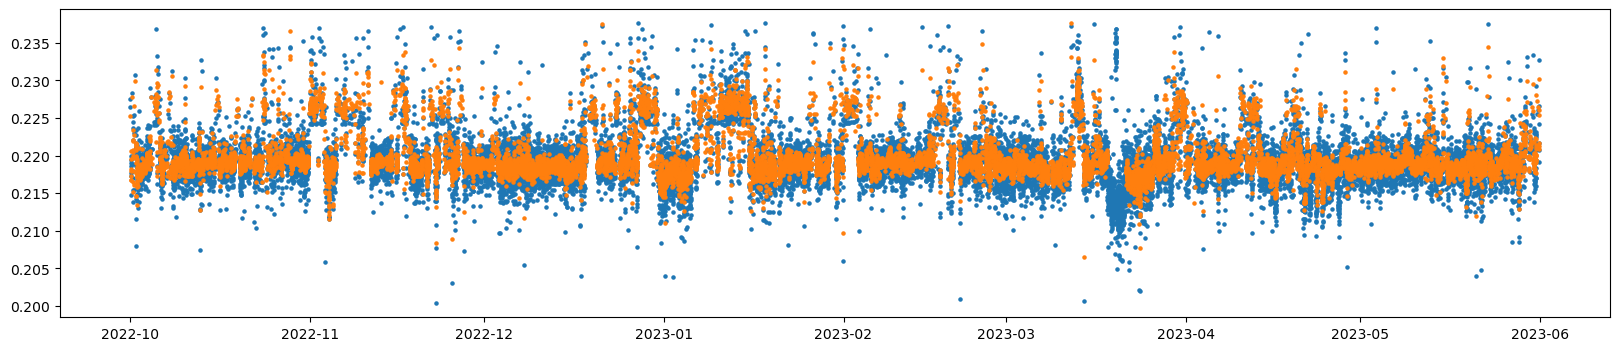

In [6]:
y = SS1_frequency.copy().dropna()
X = angle_transformed_inputs.copy().loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgbreg = XGBRegressor()
xgbreg.fit(X_train, y_train)
predictions = xgbreg.predict(X)
plt.figure(figsize=(20,4))
plt.scatter(SS1_frequency.index, SS1_frequency, s=5)
plt.scatter(X.index, predictions, s=5)

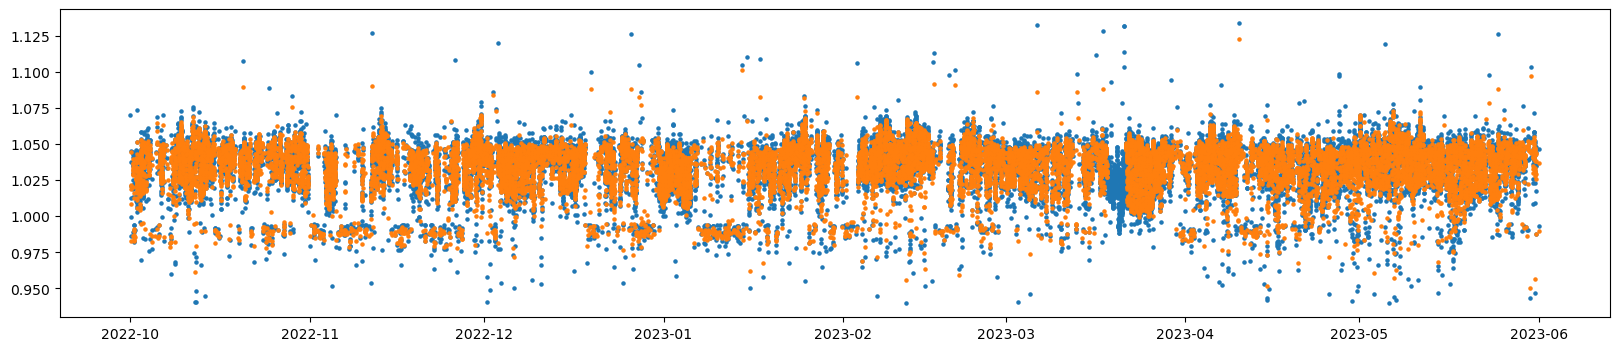

In [7]:
y = SS2_frequency.copy().dropna()
X = angle_transformed_inputs.copy().loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgbreg = XGBRegressor()
xgbreg.fit(X_train, y_train)
predictions = xgbreg.predict(X)
plt.figure(figsize=(20,4))
plt.scatter(SS2_frequency.index, SS2_frequency, s=5)
plt.scatter(X.index, predictions, s=5)

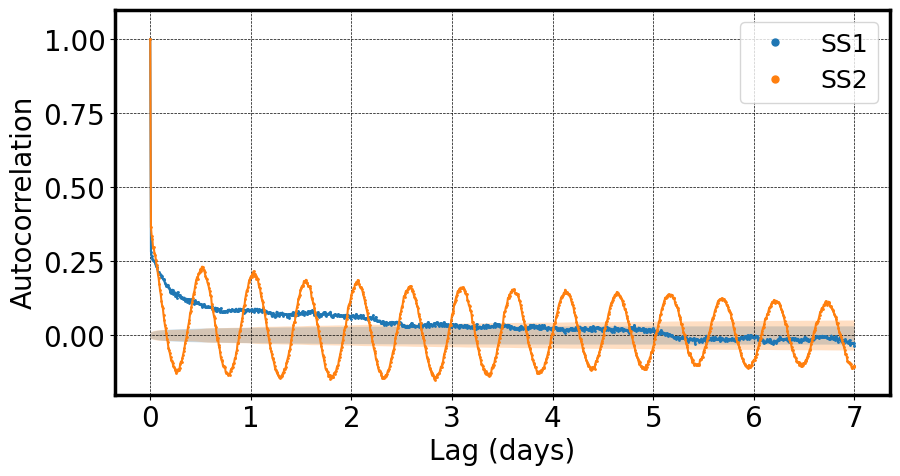

In [14]:
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

# Resample the series to fill missing indices and assign NaN values
resampled_SS1_frequency = SS1_frequency.resample('10min').asfreq()
resampled_SS2_frequency = SS2_frequency.resample('10min').asfreq()
resampled_freqyencies = pd.concat([resampled_SS1_frequency, resampled_SS2_frequency], axis=1)
resampled_freqyencies.columns = ['SS1', 'SS2']

# Calculate and plot autocorrelations
plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(10, 5))
fig = plot_acf(resampled_SS1_frequency, missing='conservative', lags=7*144, ax=ax, 
        use_vlines=False, auto_ylims=True, markersize=1,
        alpha = 0.05, linestyle='-')

fig = plot_acf(resampled_SS2_frequency, missing='conservative', lags=7*144, ax=ax,
        use_vlines=False,auto_ylims=True, markersize=1,
        alpha = 0.05, linestyle='-')

fig.set_size_inches(10, 5)
plt.ylim([-0.2, 1.1])
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
plt.title('')

plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
# Increase the width of the spines
ax.spines['left'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['top'].set_linewidth(2.5)

# access legend objects automatically created from data
handles, labels = plt.gca().get_legend_handles_labels()

point1 = Line2D([0], [0], label='SS1', marker='o', markersize=5, 
         markeredgecolor='tab:blue', markerfacecolor='tab:blue', linestyle='')
point2 = Line2D([0], [0], label='SS2', marker='o', markersize=5, 
         markeredgecolor='tab:orange', markerfacecolor='tab:orange', linestyle='')

# add manual symbols to auto legend
handles.extend([point1, point2])

plt.legend(handles=handles, fontsize=18, loc='upper right')
# Adjust the x-axis tick frequency
plt.xticks(np.arange(0, 8*144, 144), np.arange(0, 8, 1))
plt.show()

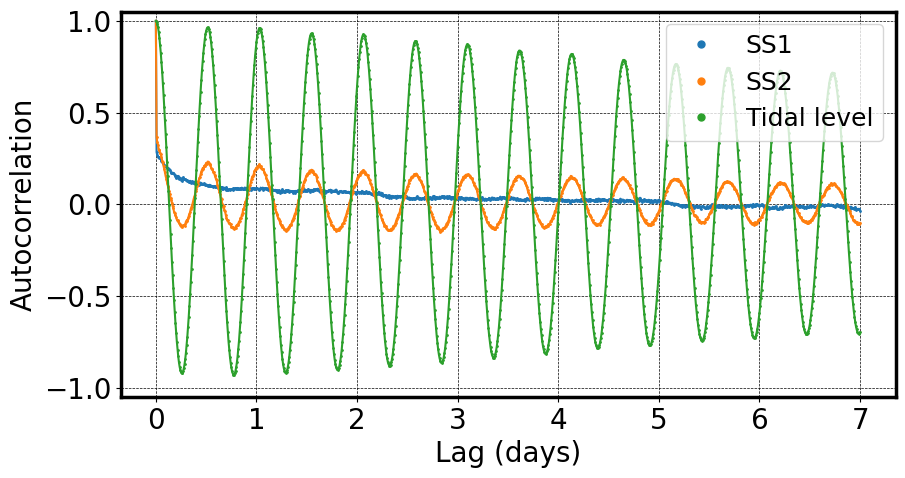

In [15]:
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

# Resample the series to fill missing indices and assign NaN values
resampled_SS1_frequency = SS1_frequency.resample('10min').asfreq()
resampled_SS2_frequency = SS2_frequency.resample('10min').asfreq()
resampled_freqyencies = pd.concat([resampled_SS1_frequency, resampled_SS2_frequency], axis=1)
resampled_freqyencies.columns = ['SS1', 'SS2']

# Calculate and plot autocorrelations
plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(10, 5))
fig = plot_acf(resampled_SS1_frequency, missing='conservative', lags=7*144, ax=ax, 
        use_vlines=False, auto_ylims=True, markersize=1,
        alpha = 1, linestyle='-')

fig = plot_acf(resampled_SS2_frequency, missing='conservative', lags=7*144, ax=ax,
        use_vlines=False,auto_ylims=True, markersize=1,
        alpha = 1, linestyle='-')

plot_acf(mvbc_data['mvbc_WandelaarMeasuringpile_Tide_TAW'], missing='conservative', lags=7*144, ax=ax, 
        use_vlines=False, auto_ylims=True, markersize=1,
        alpha = 1, linestyle='-')

fig.set_size_inches(10, 5)
plt.ylim([-1.05, 1.05])
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
plt.title('')

plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
# Increase the width of the spines
ax.spines['left'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['top'].set_linewidth(2.5)

# access legend objects automatically created from data
handles, labels = plt.gca().get_legend_handles_labels()

point1 = Line2D([0], [0], label='SS1', marker='o', markersize=5, 
         markeredgecolor='tab:blue', markerfacecolor='tab:blue', linestyle='')
point2 = Line2D([0], [0], label='SS2', marker='o', markersize=5, 
         markeredgecolor='tab:orange', markerfacecolor='tab:orange', linestyle='')
point3 = Line2D([0], [0], label='Tidal level', marker='o', markersize=5, 
         markeredgecolor='tab:green', markerfacecolor='tab:green', linestyle='')

# add manual symbols to auto legend
handles.extend([point1, point2, point3])

plt.legend(handles=handles, fontsize=18, loc='upper right')
# Adjust the x-axis tick frequency
plt.xticks(np.arange(0, 8*144, 144), np.arange(0, 8, 1))
plt.show()

# Data Selection for SS1

In [18]:
### RECURSIVE FEATURE ELIMINATION (RFE) ###
import xgboost as xgb
import warnings

y = SS1_frequency.copy().dropna()
X = inputs.copy().loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

warnings.filterwarnings('ignore')
regr_xgb = xgb.XGBRegressor()
model = BoostRFE(regr_xgb, step=1, importance_type='shap_importances',
            train_importance=True, min_features_to_select=2, verbose=0)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(r2_score(y_test, model.predict(X_test)))
print(mean_squared_error(y_test, model.predict(X_test)))
print(mean_absolute_error(y_test, model.predict(X_test)))
print(mean_absolute_percentage_error(y_test, model.predict(X_test)))

print('kept columns', inputs.columns[model.support_])
print('removed columns', inputs.columns[~model.support_])

0.5287533448555588
5.0712414198248875e-06
0.0016425889767201444
0.007472074205717363
kept columns Index(['mean_NW2_C02_rpm', 'mean_NW2_C02_pitch'], dtype='object')
removed columns Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_C02_yaw',
       'mean_NW2_C02_power', 'mean_NW2_C02_windspeed',
       'mean_NW2_C02_winddirection'],
      dtype='object')


# Data Selection for SS2

In [16]:
### RECURSIVE FEATURE ELIMINATION (RFE) ###
import xgboost as xgb
import warnings

y = SS2_frequency.copy().dropna()
X = angle_transformed_inputs.copy().loc[y.index].dropna()
y = y.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

warnings.filterwarnings('ignore')
regr_xgb = xgb.XGBRegressor()
model = BoostRFE(regr_xgb, step=1, importance_type='shap_importances',
            train_importance=True, min_features_to_select=5, verbose=0)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(r2_score(y_test, model.predict(X_test)))
print(mean_squared_error(y_test, model.predict(X_test)))
print(mean_absolute_error(y_test, model.predict(X_test)))
print(mean_absolute_percentage_error(y_test, model.predict(X_test)))

print('kept columns', angle_transformed_inputs.columns[model.support_])
print('removed columns', angle_transformed_inputs.columns[~model.support_])

0.5899001188622077
0.00013055143245611607
0.007063589018193162
0.006878046580455673
kept columns Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_C02_rpm',
       'mean_NW2_C02_pitch', 'mean_NW2_C02_power', 'mean_NW2_C02_windspeed',
       'sin_mean_NW2_C02_winddirection', 'cos_mean_NW2_C02_winddirection'],
      dtype='object')
removed columns Index(['mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'sin_mean_NW2_C02_yaw', 'cos_mean_NW2_C02_yaw'],
      dtype='object')
